# **Importing Libraries**

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader, sampler
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import random

# **Data Visualization**

In [80]:
USE_GPU = True

dtype = torch.float32 # we will be using float

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [81]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
                                      transforms.Resize(size = (64,64)),
])    
transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
                                      transforms.Resize(size = (64,64)),
])

In [119]:
Flowers102_train = torchvision.datasets.Flowers102(root = './data', split='train', download = True, transform = transform_train)
trainloader = DataLoader(Flowers102_train, batch_size=4, num_workers=2, shuffle=False)
Flowers102_val = torchvision.datasets.Flowers102(root = './data', split='train', download = True, transform = transform_test)
valloader = DataLoader(Flowers102_val, batch_size=4, num_workers=2, shuffle=False)
Flowers102_test = torchvision.datasets.Flowers102(root = './data', split='test', download = True, transform = transform_test)
testloader = DataLoader(Flowers102_test, batch_size=4, num_workers=2, shuffle=True)

In [120]:
print('Train set size:', len(Flowers102_train))
print('Validation set size:', len(Flowers102_val))
print('Test set size:', len(Flowers102_test))

Train set size: 1020
Validation set size: 1020
Test set size: 6149


In [121]:
print(len(trainloader))
print(len(testloader))

255
1538


In [98]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 64, 64])
torch.Size([3, 64, 64])
48


In [100]:
img = images[1]
print(type(img))

<class 'torch.Tensor'>


In [101]:
npimg = img.numpy()
print(npimg.shape)
npimg = np.transpose(npimg, (1,2,0))
print(npimg.shape)

(3, 64, 64)
(64, 64, 3)


In [102]:
batch_size = 4

In [103]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5
  plt.figure(figsize = (batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


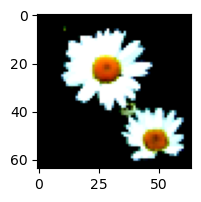

In [111]:
plt.figure(figsize = (2,2))
plt.imshow(npimg)
plt.show()

In [112]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [str(x.item()) for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


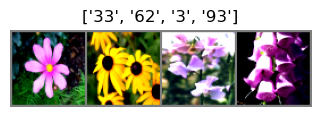

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


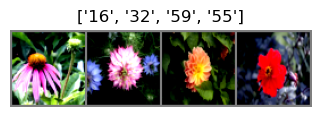

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


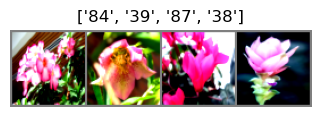

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


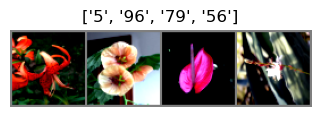

In [113]:
for i in range(4):
  show_batch_images(trainloader)

# **Data Preprocessing**

In [107]:
image_dims = (64, 64)
batch_size = 64

In [114]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [163]:
class Dataset(torchvision.datasets.Flowers102):
  def __init__(self, path, image_dims = (64, 64), n_channels = 3, split='train'):
    super().__init__(path, split, download = True)
    self.n_classes = 102
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    image = np.asarray(image).copy()
    mask = np.ones((self.image_dims[0], self.image_dims[1], self.n_channels), dtype=np.uint8)*255

    # Determine the number of masked regions (1 or 2)
    num_regions = random.randint(1, 2)

    for _ in range(num_regions):
        # Randomly choose the size of the rectangle
        rect_width = random.randint(10, max(10, int(self.image_dims[0] * 0.3)))  # Min and max width of the rectangle
        rect_height = random.randint(10, max(10, int(self.image_dims[1] * 0.3)))  # Min and max height of the rectangle

        # Randomly choose the top left corner of the rectangle such that the entire rectangle is within the image dimensions
        x1 = random.randint(0, self.image_dims[0] - rect_width)
        y1 = random.randint(0, self.image_dims[1] - rect_height)

        # Bottom right corner is determined by adding width and height to the top left corner
        x2 = x1 + rect_width
        y2 = y1 + rect_height

        # Set the pixels within the rectangle to black on the original image
        image[y1:y2, x1:x2] = 0

        cv2.rectangle(mask, (x1, y1), (x2, y2), (0, 0, 0), thickness=-1)

    return image, mask


In [164]:
Trainset = Dataset('./data', image_dims)
Valset = Dataset('./data', image_dims, split='train')
Testset = Dataset('./data', image_dims, split='test')

In [165]:
Trainloader = DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Valloader = DataLoader(Valset, batch_size = batch_size, shuffle = False)
Testloader = DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [166]:
Train_dataiter = iter(Trainloader)
Val_dataiter = iter(Valloader)
Test_dataiter = iter(Testloader)

In [167]:
X_in, X_mask, Y_out = next(Train_dataiter)
print(X_in.shape, X_mask.shape, Y_out.shape)

torch.Size([64, 3, 64, 64]) torch.Size([64, 3, 64, 64]) torch.Size([64, 3, 64, 64])


Masked Image


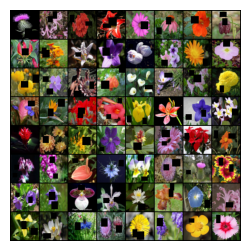

Masking Pattern


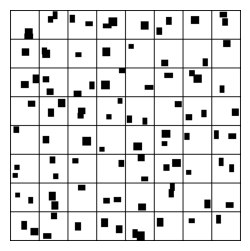

Original Image


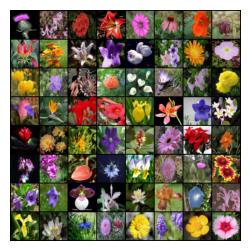

In [168]:
print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# **Training Process**

In [36]:
class PartialConv(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides=1, padding=0, dilation=1, groups=1, bias=True):
        super(PartialConv, self).__init__()

        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.input_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=bias)
        self.mask_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=False)
        
        self.window_size = kernel_size[0] * kernel_size[1]

        nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)

        output_mask = torch.clamp(output_mask, 0, 1)
  
        mask_ratio = mask_ratio * output_mask

        output = output * mask_ratio

        output = output + output_bias

        return output, output_mask

In [37]:
class EncoderLayer(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(EncoderLayer, self).__init__()
        self.p_conv_1 = PartialConv(in_filters, out_filters, (3, 3), strides=1)
        self.act_1 = nn.ReLU()
        self.p_conv_2 = PartialConv(out_filters, out_filters, (3, 3), strides=2)
        self.act_2 = nn.ReLU()

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1 = self.p_conv_1(inputs, masks)
        conv_out_1 = self.act_1(conv_out_1)

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [38]:
class DecoderLayer(nn.Module):
    def __init__(self, in_filters_1, in_filters_2):
        super(DecoderLayer, self).__init__()

        self.up_image = nn.Upsample(scale_factor=(2, 2))
        self.up_mask = nn.Upsample(scale_factor=(2, 2))
        
        self.p_conv_1 = PartialConv(in_filters_1 * 2, in_filters_1, (3, 3))
        self.act_1 = nn.LeakyReLU(negative_slope=0.2)
        self.p_conv_2 = PartialConv(in_filters_1, in_filters_2, (3, 3))
        self.act_2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, in_image, in_mask, share_image, share_mask):
        up_out = self.up_image(in_image)
        mask_out = self.up_mask(in_mask)

        concat_image = torch.cat([share_image, up_out], axis=1)
        concat_mask = torch.cat([share_mask, mask_out], axis=1)

        conv_out_1, mask_out_1 = self.p_conv_1(concat_image, concat_mask)
        conv_out_1 = self.act_1(conv_out_1)
    
        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [39]:
class InpaintingModel(nn.Module):
    def __init__(self, input_dims=(64, 64), num_channels=3):
        super(InpaintingModel, self).__init__()

        self.encoder_1 = EncoderLayer(num_channels, 32)
        self.encoder_2 = EncoderLayer(32, 64)
        self.encoder_3 = EncoderLayer(64, 128)
        self.encoder_4 = EncoderLayer(128, 256)

        self.decoder_1 = DecoderLayer(256, 128)
        self.decoder_2 = DecoderLayer(128, 64)
        self.decoder_3 = DecoderLayer(64, 32)
        self.decoder_4 = DecoderLayer(32, 3)

        self.output_layer = nn.Sequential(
            nn.Conv2d(3, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1, conv_out_2, mask_out_2 = self.encoder_1(inputs, masks)
        conv_out_3, mask_out_3, conv_out_4, mask_out_4 = self.encoder_2(conv_out_2, mask_out_2)
        conv_out_5, mask_out_5, conv_out_6, mask_out_6 = self.encoder_3(conv_out_4, mask_out_4)
        conv_out_7, mask_out_7, conv_out_8, mask_out_8 = self.encoder_4(conv_out_6, mask_out_6)

        conv_out_9, mask_out_9, conv_out_10, mask_out_10 = self.decoder_1(conv_out_8, mask_out_8, conv_out_7, mask_out_7)
        conv_out_11, mask_out_11, conv_out_12, mask_out_12 = self.decoder_2(conv_out_6, mask_out_6, conv_out_5, mask_out_5)
        conv_out_13, mask_out_13, conv_out_14, mask_out_14 = self.decoder_3(conv_out_4, mask_out_4, conv_out_3, mask_out_3)
        conv_out_15, mask_out_15, conv_out_16, mask_out_16 = self.decoder_4(conv_out_2, mask_out_2, conv_out_1, mask_out_1)

        outputs = self.output_layer(conv_out_16)
        return outputs

In [40]:
def jaccard_coeff(dataloader):
  for (X_input, X_mask, Y_output) in dataloader:
    X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)
    outputs = model(X_input, X_mask)
    eps = 1e-15
    outputs = outputs.view(-1)
    Y_output = Y_output.view(-1)
    intersection = (outputs * Y_output).sum()
    union = (outputs.sum() + Y_output.sum()) - intersection
  return (intersection / (union + eps))

In [41]:
model = InpaintingModel()
model = model.to(device)

In [42]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters())

Min loss 0.08906
Iteration: 0/1, Loss: 0.08906, Jaccard Coeff: 0.26463
Min loss 0.07951
Iteration: 0/1, Loss: 0.09130, Jaccard Coeff: 0.26937
Iteration: 0/1, Loss: 0.08597, Jaccard Coeff: 0.26363
Min loss 0.07872
Min loss 0.07858
Iteration: 0/1, Loss: 0.08013, Jaccard Coeff: 0.25532
Min loss 0.07687
Min loss 0.07551
Min loss 0.07109
Min loss 0.06949
Iteration: 0/1, Loss: 0.06949, Jaccard Coeff: 0.25177
Min loss 0.06812
Min loss 0.06757
Min loss 0.06663
Iteration: 0/1, Loss: 0.07044, Jaccard Coeff: 0.24086
Min loss 0.06502
Min loss 0.06324
Iteration: 0/1, Loss: 0.06370, Jaccard Coeff: 0.23071
Min loss 0.06147
Min loss 0.05892
Iteration: 0/1, Loss: 0.06639, Jaccard Coeff: 0.24057
Min loss 0.05876
Min loss 0.05548
Min loss 0.05370
Iteration: 0/1, Loss: 0.05935, Jaccard Coeff: 0.23642
Min loss 0.05325
Min loss 0.05303
Min loss 0.05257
Min loss 0.05238
Min loss 0.05161
Min loss 0.05113
Min loss 0.05032
Min loss 0.04807
Min loss 0.04729
Min loss 0.04211
Iteration: 0/1, Loss: 0.04682, Jaccard

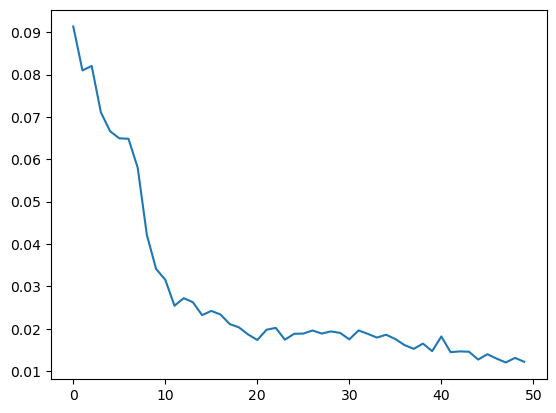

CPU times: user 2h 3min 25s, sys: 2h 27min 53s, total: 4h 31min 18s
Wall time: 46min 39s


In [43]:
%%time
loss_epoch_arr = []
max_epochs = 50

min_loss = 1000

n_iters = np.ceil(len(Trainloader)/batch_size)
for epoch in range(max_epochs):
    model.train()                               
    for i, (X_input, X_mask, Y_output) in enumerate(Trainloader, 0):

        X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)

        opt.zero_grad()

        outputs = model(X_input, X_mask)
        loss = loss_fn(Y_output, outputs)
        loss.backward()

        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.5f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.5f, Jaccard Coeff: %0.5f' % (i, n_iters, loss.item(), jaccard_coeff(Trainloader)))

        del X_input, X_mask, Y_output
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())    

plt.plot(loss_epoch_arr)
plt.show()

In [34]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [35]:
print(model)

InpaintingModel(
  (encoder_1): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (act_2): ReLU()
  )
  (encoder_2): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fals

In [36]:
torch.save(model.state_dict(), './model.pt')

In [37]:
weight_layer0 = list(model.parameters())[0].cpu()
weight_layer0 = weight_layer0.data.numpy()

In [38]:
print(weight_layer0.shape)

(32, 3, 3, 3)


[]

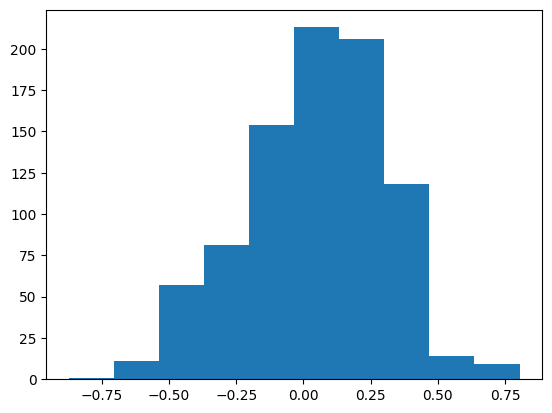

In [39]:
plt.hist(weight_layer0.ravel())
plt.plot()

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


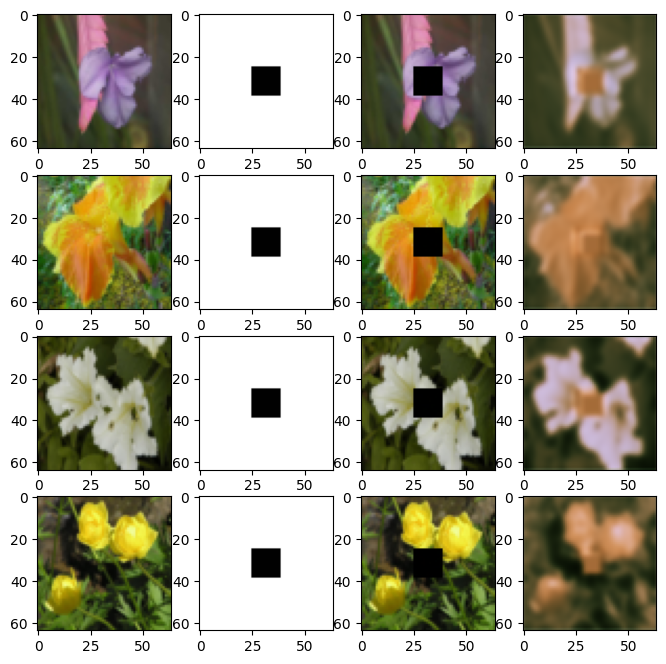

In [40]:
sample_inputs, sample_masks, sample_truths = next(Train_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)
    print(sample_inputs.size())
    print(sample_preds.size())

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))

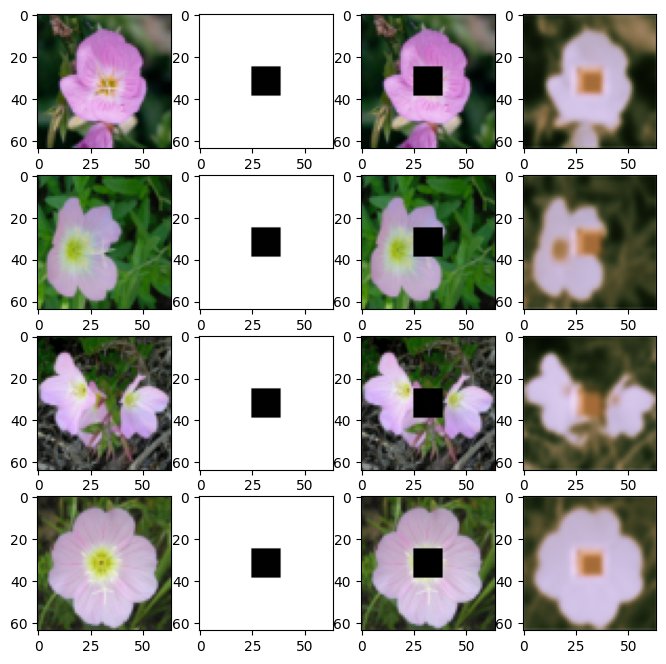

In [41]:
sample_inputs, sample_masks, sample_truths = next(Test_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))

In [42]:
# Call this to download the model weights
"""
model = InpaintingModel()
model.load_state_dict(torch.load('./model.pt'))
model.eval()
"""

"\nmodel = InpaintingModel()\nmodel.load_state_dict(torch.load('./model.pt'))\nmodel.eval()\n"